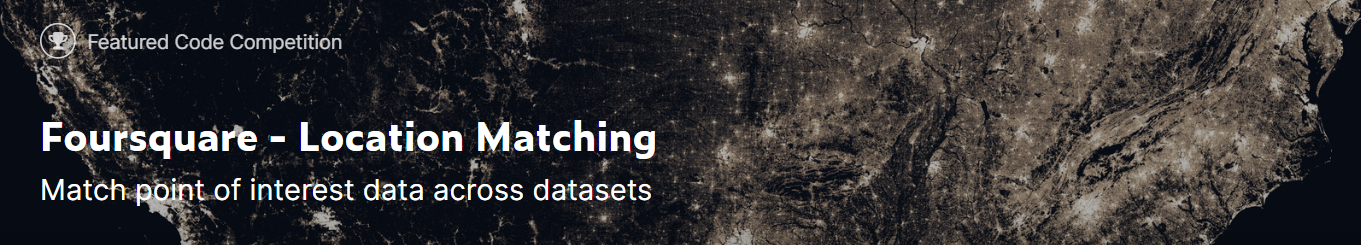

## Data Description
The data presented here comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. Your task is to determine which place entries describe the same point-of-interest. Though the data entries may represent or resemble entries for real places, they may also contain artificial information or additional noise.

### Training Data
train.csv - The training set, comprising eleven attribute fields for over one million place entries, together with:
id - A unique identifier for each entry.
point_of_interest - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI.
pairs.csv - A pregenerated set of pairs of place entries from train.csv designed to improve detection of matches. You may wish to generate additional pairs to improve your model's ability to discriminate POIs.
match - Whether (True or False) the pair of entries describes a common POI.

### Example Test Data
To help you author submission code, we include a few example instances selected from the test set. When you submit your notebook for scoring, this example data will be replaced by the actual test data. The actual test set has approximately 600,000 place entries with POIs that are distinct from the POIs in the training set.

test.csv - A set of place entries with their recorded attribute fields, similar to the training set.
sample_submission.csv - A sample submission file in the correct format.
id - The unique identifier for a place entry, one for each entry in the test set.
matches - A space delimited list of IDs for entries in the test set matching the given ID. Place entries always self-match.

## Evaluation metric
Submissions are evaluated by the mean Intersection over Union (IoU, aka the Jaccard index) of the ground-truth entry matches and the predicted entry matches. The mean is taken sample-wise, meaning that an IoU score is calculated for each row in the submission file, and the final score is their average.

## Import packages

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from geopy import distance

## Load data

In [ ]:
train_data = pd.read_csv('../input/foursquare-location-matching/train.csv')
test_data = pd.read_csv('../input/foursquare-location-matching/test.csv')
sample_submission_data = pd.read_csv('../input/foursquare-location-matching/sample_submission.csv')
pairs_data = pd.read_csv('../input/foursquare-location-matching/pairs.csv')

## EDA

#### Looking at data

In [ ]:
print(train_data.shape)
print('# Places:', train_data['id'].nunique())
train_data.head()

In [ ]:
print(test_data.shape)
test_data.head()

In [ ]:
# Checking if test data place IDs are in train data
test_data[test_data['id'].isin(train_data['id'].tolist())]

In [ ]:
print(sample_submission_data.shape)
sample_submission_data.head()

In [ ]:
print(pairs_data.shape)
pairs_data.head()

In [ ]:
# Matches
pairs_data['match'].value_counts()

In [ ]:
# Check id all IDs in pairs data matches with available IDs in train data
pairs_data_all_ids = list(set(list(set(pairs_data['id_1'].tolist())) + list(set(pairs_data['id_2'].tolist()))))
len(set(pairs_data_all_ids))==len(set(pairs_data_all_ids).intersection(set(train_data['id'].tolist())))

In [ ]:
# Checking if match is true only when the POI is the same across 2 IDs
print(pairs_data.shape)
pairs_data = pairs_data.merge(train_data[['id','point_of_interest']], how = 'left', left_on = 'id_1', right_on = 'id').rename(columns = {'point_of_interest':'point_of_interest_id_1'})
pairs_data = pairs_data.merge(train_data[['id','point_of_interest']], how = 'left', left_on = 'id_2', right_on = 'id').rename(columns = {'point_of_interest':'point_of_interest_id_2'})
print(pairs_data.shape)
pairs_data_valid_matches = pairs_data[pairs_data['match']==True]
pairs_data_valid_matches.shape[0] == pairs_data_valid_matches[pairs_data_valid_matches['point_of_interest_id_1']==pairs_data_valid_matches['point_of_interest_id_2']].shape[0]

In [ ]:
# Checking if test data place IDs are in pairs data
pairs_data[pairs_data['id_1'].isin(test_data['id'].tolist())]

In [ ]:
# Look at a sample place ID
sample_id = 'E_0283d9f61e569d'
print('\nPairs data records:')
display(pairs_data[pairs_data['id_1']==sample_id].head().iloc[:,:12])
display(pairs_data[pairs_data['id_1']==sample_id].head().iloc[:,12:])
print('\nTrain data records:')
display(train_data[train_data['id']==sample_id].head())
display(train_data[train_data['id'].isin(pairs_data[pairs_data['id_1']==sample_id]['id_2'].tolist())].head())

### Fill rate

In [ ]:
fill_rate_df = train_data.isnull().sum().reset_index().rename(columns = {0:'# Blanks'})
fill_rate_df['% Blank records'] = fill_rate_df['# Blanks']*100/train_data.shape[0]
fill_rate_df.sort_values(by = '# Blanks', ascending = False).reset_index(drop = True)

### Distribution by metadata - categories and countries

In [ ]:
categories_in_train_data = train_data['categories'].value_counts().reset_index().rename(columns = {'index':'Category', 'categories':'# Places'})
print('\nNumber of categories in train data:', categories_in_train_data.shape[0])
categories_in_train_data.head(10)

In [ ]:
countries_in_train_data = train_data['country'].value_counts().reset_index().rename(columns = {'index':'Country', 'country':'# Places'})
print('\nNumber of countries in train data:', countries_in_train_data.shape[0])
countries_in_train_data.head(10)

### Calculate distance between 2 places based on lat long

WGS-84 ellipsoid model is used to calculate distance: https://geopy.readthedocs.io/en/stable/#module-geopy.distance

In [ ]:
sample_id_1 = 'E_0283d9f61e569d'
sample_id_2 = 'E_000001272c6c5d'
coordinates_1 = (train_data[train_data['id']==sample_id_1]['latitude'].iloc[0], train_data[train_data['id']==sample_id_1]['longitude'].iloc[0])
coordinates_2 = (train_data[train_data['id']==sample_id_2]['latitude'].iloc[0], train_data[train_data['id']==sample_id_2]['longitude'].iloc[0])
print('Distance between places with IDs', sample_id_1, 'and', sample_id_2, 'is', distance.distance(coordinates_1, coordinates_2).miles, 'miles')

In [ ]:
def get_distance_from_lat_long(x):
    if pd.isnull(x['latitude']) or pd.isnull(x['longitude']) or pd.isnull(x['latitude_1']) or pd.isnull(x['longitude_1']):
        return np.NaN
    else:
        coordinates_1 = (x['latitude'], x['longitude'])
        coordinates_2 = (x['latitude_1'], x['longitude_1'])
        return distance.distance(coordinates_1, coordinates_2).miles
    
def get_distance_from_all_places(data, sample_id):
    data['id_1'] = sample_id
    data = data.merge(data[['id','latitude','longitude']].rename(columns = {'id':'id_1', 'latitude':'latitude_1', 'longitude':'longitude_1'}), how = 'left', on = 'id_1')
    data['distance (miles)'] = data.progress_apply(lambda x: get_distance_from_lat_long(x), axis = 1)
    return data[['id_1','latitude_1','longitude_1','id','latitude','longitude', 'distance (miles)']]

In [ ]:
sample_id_1 = 'E_0283d9f61e569d'
train_data_distances = get_distance_from_all_places(train_data, sample_id_1)

In [ ]:
print('Below are the best matches based on distance')
train_data_distances.sort_values(by = 'distance (miles)', ascending = True).reset_index(drop = True).head()

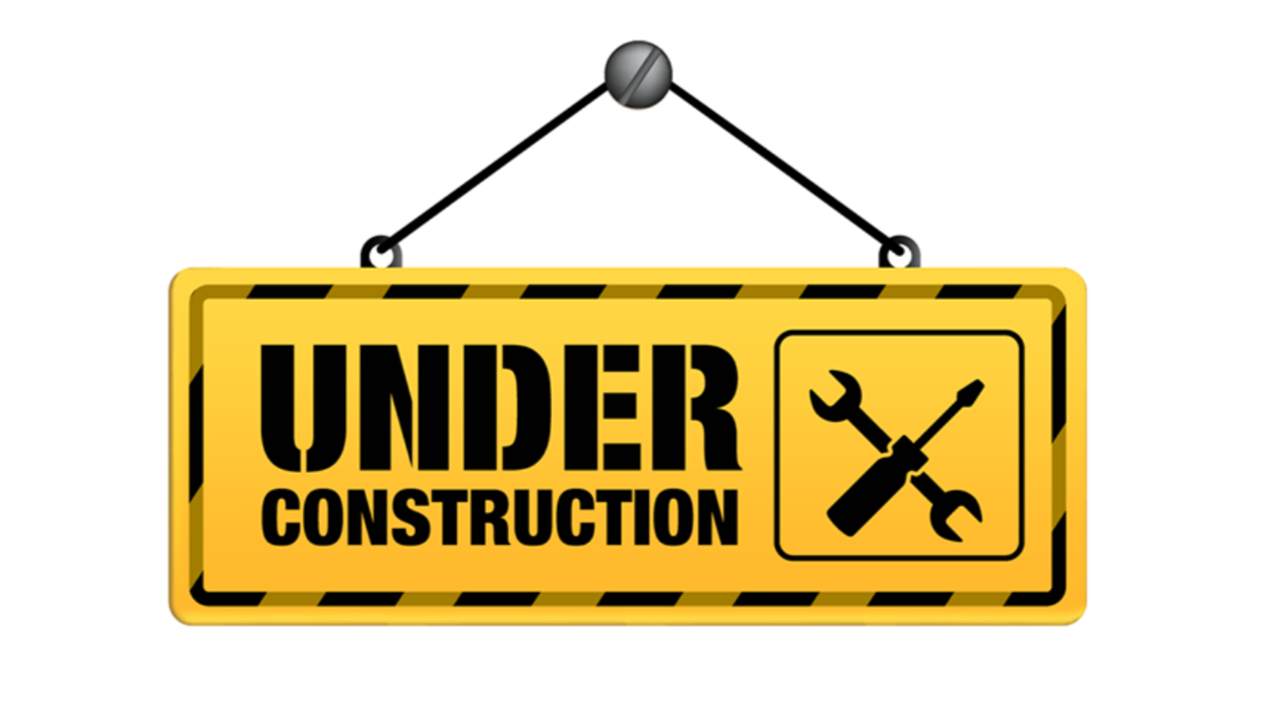